<h1> Time series prediction using RNNs, with TensorFlow and Cloud ML Engine </h1>

This notebook illustrates:
<ol>
<li> Creating a Recurrent Neural Network in TensorFlow
<li> Creating a Custom Estimator in tf.contrib.learn 
<li> Training on Cloud ML Engine
</ol>

<p>

<h3> Simulate some time-series data </h3>

A simple sinusoid, to start ...

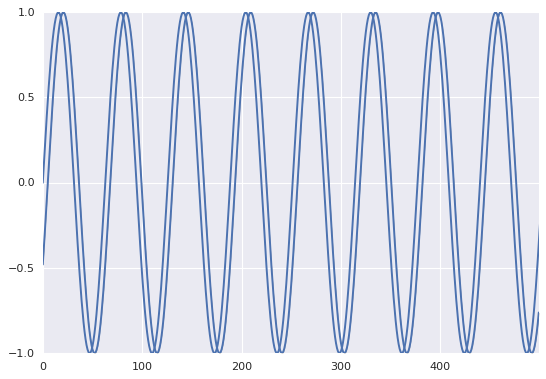

In [36]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import pandas as pd

# simulated data
data_size  = 1000
x = np.sin(np.arange(0,data_size) * 0.1)
sns.tsplot(x);
y = np.sin(np.arange(0,data_size/2) * 0.1 - 0.5)  # time-shifted version
sns.tsplot(y);

In [37]:
def to_csv(df, filename):
  outdf = df.copy(deep=False)
  outdf.loc[:, 'key'] = np.arange(0, len(outdf)) # rownumber as key
  outdf.to_csv(filename, header=False, index_label=False, index=False)

df = pd.DataFrame.from_dict({'x': x})
to_csv(df, 'train.csv')
df = pd.DataFrame.from_dict({'y': y})
to_csv(df, 'valid.csv')

In [38]:
!head -5 train.csv valid.csv

==> train.csv <==
0.0,0
0.0998334166468,1
0.198669330795,2
0.295520206661,3
0.389418342309,4

==> valid.csv <==
-0.479425538604,0
-0.389418342309,1
-0.295520206661,2
-0.198669330795,3
-0.0998334166468,4


The key will come in useful to illustrate how to discard unnecessary columns from your CSV file.

<h2> Create RNN code in TensorFlow </h2>

For more info, see:
<ol>
<li> http://colah.github.io/posts/2015-08-Understanding-LSTMs/ for the theory
<li> https://www.tensorflow.org/tutorials/recurrent for explanations
<li> https://github.com/tensorflow/models/tree/master/tutorials/rnn/ptb for sample code
</ol>

<p>

<h3> Step 1: Create an input function </h3>

The input function for a RNN needs to "unroll" the timeseries for inputs, and time-shift the timeseries for the labels. That is what this code does -- even though we have only one input variable (x), we will create a model that takes NUM_STEPS input variables. We'll create these from the original time series by running a moving window. Hence the unroll.

The goal is to predict the very next point. Hence the time-shift.

In [39]:
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics

# change as needed
CSV_COLUMNS = ['rawdata', 'key']
DEFAULTS = [[0.0],['nokey']]   # one default per column. The type here is important (float/string)
TIMESERIES_COL = 'rawdata'
BATCH_SIZE = 20
NUM_STEPS = 5  # how many steps that the RNN should look "back"
LSTM_SIZE = 3  # the greater the size, the more complex the model

# prepare data for RNNs
def unroll_and_shift(raw_data, batch_size, num_steps, name='unroll_and_shift'):
  """Iterate on the raw data.
  This chunks up raw_data into batches of examples and returns Tensors that
  are drawn from these batches.
  Args:
    raw_data: the time-series data
    batch_size: int, the batch size.
    num_steps: int, the number of unrolls.
    name: the name of this operation (optional).
  Returns:
    A pair of Tensors, each shaped [batch_size, num_steps]. The second element
    of the tuple is the same data time-shifted to the right by one.
  Raises:
    tf.errors.InvalidArgumentError: if batch_size or num_steps are too high.
  """
  with tf.name_scope(name, "UnrollInput", [raw_data, batch_size, num_steps]):
    raw_data = tf.convert_to_tensor(raw_data, name="raw_data", dtype=tf.float32)

    data_len = tf.size(raw_data)
    batch_len = data_len // batch_size
    data = tf.reshape(raw_data[0 : batch_size * batch_len],
                      [batch_size, batch_len])

    epoch_size = (batch_len - 1) // num_steps
    assertion = tf.assert_positive(
        epoch_size,
        message="epoch_size == 0, decrease batch_size or num_steps")
    with tf.control_dependencies([assertion]):
      epoch_size = tf.identity(epoch_size, name="epoch_size")

    i = tf.train.range_input_producer(epoch_size, shuffle=False).dequeue()
    x = tf.strided_slice(data, [0, i * num_steps],
                         [batch_size, (i + 1) * num_steps])
    x.set_shape([batch_size, num_steps])
    y = tf.strided_slice(data, [0, i * num_steps + 1],
                         [batch_size, (i + 1) * num_steps + 1])
    y.set_shape([batch_size, num_steps])
    return x, y
 
# read data and convert to needed format
def read_dataset(filename, mode=tf.contrib.learn.ModeKeys.TRAIN):  
  def _input_fn():
    num_epochs = 100 if mode == tf.contrib.learn.ModeKeys.TRAIN else 1
    filename_queue = tf.train.string_input_producer(
        [filename], num_epochs=num_epochs, shuffle=True)
    reader = tf.TextLineReader()
    _, value = reader.read_up_to(filename_queue, num_records=batch_size)

    value_column = tf.expand_dims(value, -1)
    columns = tf.decode_csv(value_column, record_defaults=DEFAULTS)   
    raw_data = dict(zip(CSV_COLUMNS, columns))
    raw_data, label = unroll_and_shift(raw_data[TIMESERIES_COL], BATCH_SIZE, NUM_STEPS)
    return {TIMESERIES_COL: raw_data}, label   # dict of features, label
  return _input_fn

def get_train():
  return read_dataset('train.csv', mode=tf.contrib.learn.ModeKeys.TRAIN)

def get_valid():
  return read_dataset('valid.csv', mode=tf.contrib.learn.ModeKeys.EVAL)

def experiment_fn(output_dir):
    feature_cols = [
       tflayers.real_valued_column(TIMESERIES_COL),
    ]
    
    lstm = tf.contrib.rnn.BasicLSTMCell(LSTM_SIZE)
    
    # now what?????
    return tflearn.Experiment(
        tflearn.Estimator(model_fn=lstm, model_dir=output_dir),
        train_input_fn=get_train(),
        eval_input_fn=get_valid(),
        eval_metrics={
            'rmse': tflearn.MetricSpec(
                metric_fn=metrics.streaming_root_mean_squared_error
            )
        }
    )

shutil.rmtree('trainoutput', ignore_errors=True) # start fresh each time
learn_runner.run(experiment_fn, 'trainoutput')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f667c387350>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}
Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.


TypeError: 'Tensor' object is not iterable.